### Libs import

In [1]:
import numpy as np
import pandas as pd
import warnings


from numba import  njit
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
from tqdm.notebook import tqdm

from processes import StochasticProcess, CIRprocess


warnings.filterwarnings("ignore")

1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

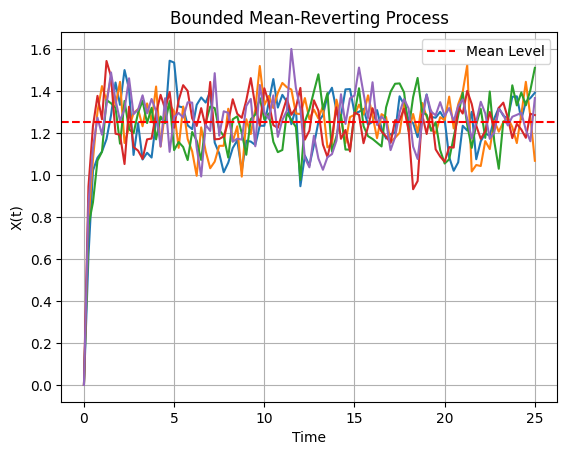

In [516]:
class BoundedMeanRevertingProcess(StochasticProcess):
    def __init__(self, params=None, T=1.0, Nx=10, Nt=100, a=0.0, b=1.0, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.a = a
        self.b = b
        # Устанавливаем уровень возврата к среднему значению
        self.mean_reversion_level = (b - a) / np.random.uniform(a, b)
        
        # Устанавливаем параметры по умолчанию, если они не заданы
        if self.params is None:
            self.params = [2.5, self.mean_reversion_level, 0.2]  # [скорость возврата, уровень среднего, волатильность]

    @staticmethod
    def bxt(x, t, params):
        mean_reversion_rate = params[0]  # скорость возврата к среднему
        mean_level = params[1]  # уровень среднего
        return mean_reversion_rate * (mean_level - x)

    @staticmethod
    def sigmaxt(x, t, params):
        volatility = params[2]  # волатильность
        return volatility

    def enforce_bounds(self, x):
        """ Отражение значений на границе [a, b] """
        return np.maximum(self.a, np.minimum(self.b, x))

    def generate_path(self):
        t_data, x_data = self.EulerSolution()

        # Применяем ограничение на [a, b]
        x_data = np.apply_along_axis(self.enforce_bounds, 1, x_data)
        return t_data, x_data

    def plot_path(self):
        t_data, x_data = self.generate_path()

        # График с траекторией и средней линией
        plt.plot(t_data, x_data)
        plt.axhline(y=self.mean_reversion_level, color='r', linestyle='--', label="Mean Level")
        plt.xlabel("Time")
        plt.ylabel("X(t)")
        plt.legend()
        plt.grid(True)
        plt.title("Bounded Mean-Reverting Process")
        plt.show()

T = 25
nx = 5
nt = 100
a = 0
b = 15

# Пример использования
process = BoundedMeanRevertingProcess(T=T, Nx=nx, Nt=nt, a=a, b=b)
process.plot_path()

2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

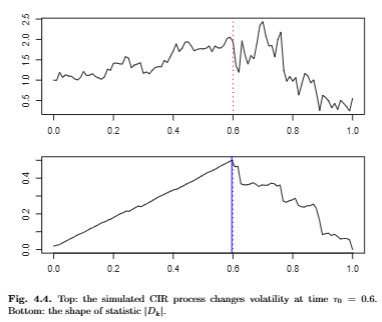

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

In [244]:
class CIRprocessWithChange(CIRprocess):
    def __init__(self, params, T, Nx, Nt, tau_0=0.6, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.tau_0 = tau_0

    @staticmethod
    @njit
    def sigmaxt(x, t, params, tau_0):
        theta = params[2] if t < tau_0 else params[3]
        return theta * np.sqrt(np.maximum(x, 0))

    def ExactSolutionWithChange(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1, theta2, theta3, theta4 = self.params[0], self.params[1], self.params[2], self.params[3]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size=(self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            t = t_data[i]
            theta = theta3 if t < self.tau_0 else theta4
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t) + theta1 / theta2
            Ito_integral_sum = (Ito_integral_sum + theta * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum

        return t_data, x_data

def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

def compute_drift_estimation(x_data, bandwidth=0.01):
    def drift_function(x):
        diffs = x_data - x
        weights = gaussian_kernel(diffs / bandwidth)
        weights = weights[:-1] / np.sum(weights[:-1])
        dx = np.diff(x_data, axis=0)
        drift_estimate = np.sum(weights * dx)
        return drift_estimate
    return drift_function

def compute_residuals(x_data, drift_estimation, delta_t):
    residuals = []
    for i in range(1, len(x_data)):
        drift = drift_estimation(x_data[i - 1])
        residual = (x_data[i] - x_data[i - 1] - drift * delta_t) / np.sqrt(delta_t)
        residuals.append(residual)
    return np.array(residuals)

def compute_cusum_statistic(residuals):
    n = len(residuals)
    S = np.cumsum(residuals - np.mean(residuals))
    cusum_statistic = np.abs(S)
    min_idx = np.argmax(cusum_statistic)
    return min_idx, cusum_statistic

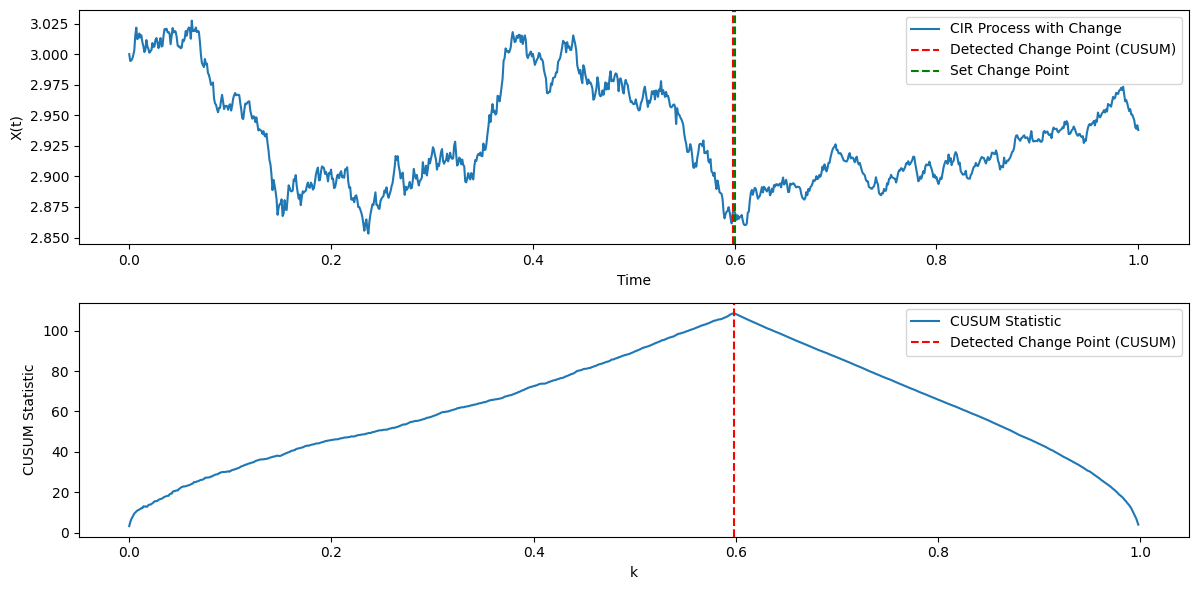

In [253]:
def compute_statistic_dk(residuals):
    n = len(residuals)
    S_n = np.sum(residuals**2)
    D_k = []

    # Обработка только до конца временной серии
    for k in range(1, n):
        S_k = np.sum(residuals[:k]**2)
        S_nk = S_n - S_k
        V_k = np.sqrt(k * (n - k) / n**2) * (S_nk / (n - k) - S_k / k)
        D_k.append(V_k)

    # Преобразуем индексы в правильный временной масштаб
    D_k = np.array(D_k)
    min_dk_idx = np.argmin(np.abs(D_k))
    
    # Пересчет индекса в рамках временного интервала t_data
    change_point_idx = int(min_dk_idx * (len(t_data) / n))
    return change_point_idx, np.abs(D_k)

# Повторный запуск и построение графика
T, Nx, Nt = 1.0, 100, 1000
params = [6, 2, 1, 0.5]
cir_process = CIRprocessWithChange(params, T, Nx, Nt, tau_0=0.6)
t_data, x_data = cir_process.ExactSolutionWithChange()

# Вычисление остатков и статистики
drift_estimation = compute_drift_estimation(x_data)
residuals = compute_residuals(x_data, drift_estimation, T / Nt)
change_point_idx, cusum_stat = compute_statistic_dk(residuals)
statistics = pd.Series(cusum_stat)
best_idx = statistics[statistics == statistics.max()].index[0]

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_data, x_data.mean(axis=1), label="CIR Process with Change")
plt.axvline(x=t_data[best_idx], color="r", linestyle="--", label="Detected Change Point (CUSUM)")
plt.axvline(x=cir_process.tau_0, color="g", linestyle="--", label="Set Change Point")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, 0.999, 0.001), cusum_stat, label="CUSUM Statistic")
plt.axvline(x=np.arange(0, 0.999, 0.001)[best_idx], color="r", linestyle="--", label="Detected Change Point (CUSUM)")
plt.xlabel("k")
plt.ylabel("CUSUM Statistic")
plt.legend()

plt.tight_layout()
plt.show()

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

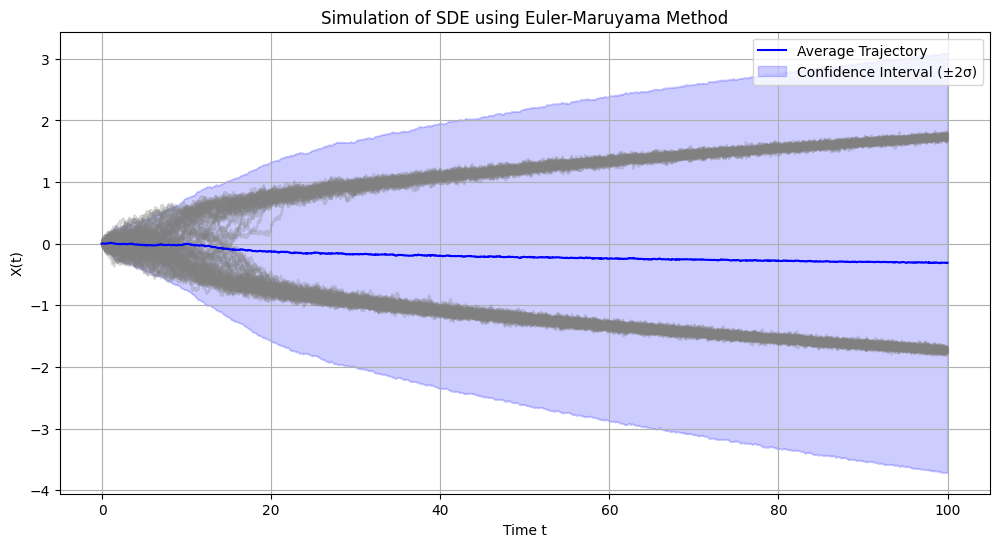

In [272]:
# Parameters
x0 = 0.0
t0 = 0.0
T = 100.0
delta_t = 0.01
num_steps = int(T / delta_t)
num_trajectories = 100

# Time vector
t = np.linspace(t0, T, num_steps + 1)

# Preallocate array to store trajectories
X = np.zeros((num_trajectories, num_steps + 1))

# Function definitions
def a(x, t):
    return 0.03 * t * x - x**3

def b(x, t):
    return 0.1

# Simulation using Euler-Maruyama method
np.random.seed(0)  # For reproducibility
for i in range(num_trajectories):
    X_i = np.zeros(num_steps + 1)
    X_i[0] = x0
    for n in range(num_steps):
        t_n = t[n]
        X_n = X_i[n]
        delta_W = np.random.normal(0.0, np.sqrt(delta_t))
        # Euler-Maruyama update
        X_i[n + 1] = X_n + a(X_n, t_n) * delta_t + b(X_n, t_n) * delta_W
    X[i, :] = X_i

# Calculate average trajectory and confidence intervals
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
upper_confidence = mean_X + 2 * std_X
lower_confidence = mean_X - 2 * std_X

# Plotting
plt.figure(figsize=(12, 6))

# Plot all trajectories in light grey
for i in range(num_trajectories):
    plt.plot(t, X[i, :], color='grey', alpha=0.3)

# Plot average trajectory
plt.plot(t, mean_X, color='blue', label='Average Trajectory')

# Plot confidence intervals
plt.fill_between(t, lower_confidence, upper_confidence, color='blue', alpha=0.2, label='Confidence Interval (±2σ)')

plt.title('Simulation of SDE using Euler-Maruyama Method')
plt.xlabel('Time t')
plt.ylabel('X(t)')
plt.legend()
plt.grid(True)
plt.show()

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


In [274]:
from scipy.stats import norm

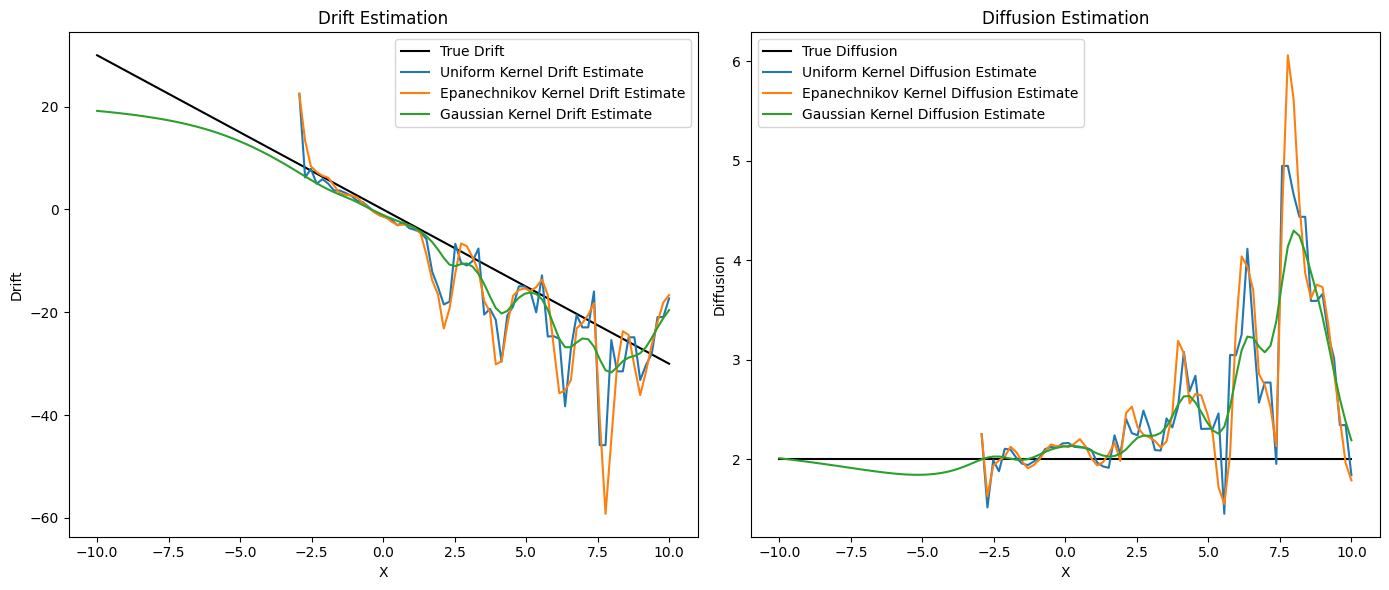

In [309]:
# Parameters for the OU process
theta1, theta2, theta3 = 0, 3, 2
X0 = 10
T = 10  # total time
dt = 0.01  # time step
N = int(T / dt)  # number of steps

# Simulate the Ornstein-Uhlenbeck process using Euler-Maruyama
time = np.linspace(0, T, N)
X = np.zeros(N)
X[0] = X0
dW = np.sqrt(dt) * np.random.randn(N - 1)  # Wiener increments

for i in range(1, N):
    X[i] = X[i - 1] + (theta1 - theta2 * X[i - 1]) * dt + theta3 * dW[i - 1]

# Bandwidth for kernel estimation
h = 0.5

# Define kernel functions
def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return norm.pdf(u)

# Non-parametric estimation functions
def estimate_drift(X, X_grid, kernel):
    drift_estimate = []
    for x0 in X_grid:
        weights = kernel((X[:-1] - x0) / h)
        weighted_dX = weights * (X[1:] - X[:-1]) / dt
        drift_estimate.append(np.sum(weighted_dX) / np.sum(weights))
    return np.array(drift_estimate)

def estimate_diffusion(X, X_grid, kernel):
    diffusion_estimate = []
    for x0 in X_grid:
        weights = kernel((X[:-1] - x0) / h)
        weighted_diffusion = weights * ((X[1:] - X[:-1]) ** 2 / dt)
        diffusion_estimate.append(np.sum(weighted_diffusion) / np.sum(weights))
    return np.sqrt(np.array(diffusion_estimate))

# Define a grid over which to estimate the drift and diffusion
X_grid = np.linspace(-10, 10, 100)

# Estimate drift and diffusion using each kernel
drift_uniform = estimate_drift(X, X_grid, uniform_kernel)
drift_epanechnikov = estimate_drift(X, X_grid, epanechnikov_kernel)
drift_gaussian = estimate_drift(X, X_grid, gaussian_kernel)

diffusion_uniform = estimate_diffusion(X, X_grid, uniform_kernel)
diffusion_epanechnikov = estimate_diffusion(X, X_grid, epanechnikov_kernel)
diffusion_gaussian = estimate_diffusion(X, X_grid, gaussian_kernel)

# Plot the estimated drift
plt.figure(figsize=(14, 6))

# True drift function
true_drift = theta1 - theta2 * X_grid

plt.subplot(1, 2, 1)
plt.plot(X_grid, true_drift, label="True Drift", color="black")
plt.plot(X_grid, drift_uniform, label="Uniform Kernel Drift Estimate")
plt.plot(X_grid, drift_epanechnikov, label="Epanechnikov Kernel Drift Estimate")
plt.plot(X_grid, drift_gaussian, label="Gaussian Kernel Drift Estimate")
plt.xlabel("X")
plt.ylabel("Drift")
plt.title("Drift Estimation")
plt.legend()

# Plot the estimated diffusion
plt.subplot(1, 2, 2)
true_diffusion = np.full_like(X_grid, theta3)

plt.plot(X_grid, true_diffusion, label="True Diffusion", color="black")
plt.plot(X_grid, diffusion_uniform, label="Uniform Kernel Diffusion Estimate")
plt.plot(X_grid, diffusion_epanechnikov, label="Epanechnikov Kernel Diffusion Estimate")
plt.plot(X_grid, diffusion_gaussian, label="Gaussian Kernel Diffusion Estimate")
plt.xlabel("X")
plt.ylabel("Diffusion")
plt.title("Diffusion Estimation")
plt.legend()

plt.tight_layout()
plt.show()

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

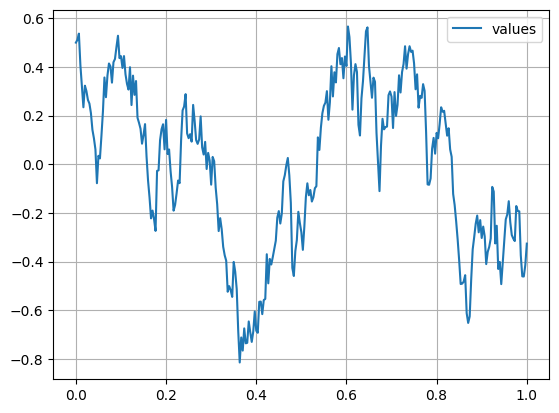

In [311]:
data = pd.read_csv('12.csv', index_col='Unnamed: 0')
data.columns = ['values']
data.plot(grid=True)
plt.show()

In [320]:
from scipy.optimize import minimize

Оценки Ornstein-Uhlenbeck:
theta: 11.110688740178825 
 mu: -0.08598414207315022 
 sigma: 1.5334347660467473

Оценки Cox-Ingersoll-Ross:
theta: 1.0 
 mu: 1e-05 
 sigma: 0.1

Оценки Geometric Brownian Motion:
mu: 0.5 
 sigma: 0.5

MSE Ornstein-Uhlenbeck: 0.15278488956667896
MSE Geometric Brownian Motion: 0.49440966049243884
MSE Cox-Ingersoll-Ross: 0.21614302704391222


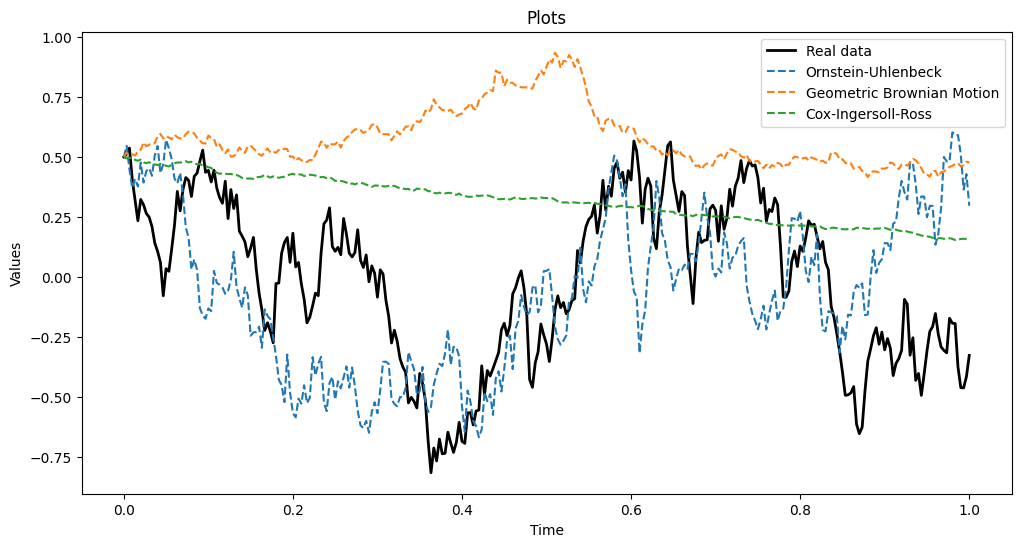

In [522]:
data = pd.read_csv('12.csv')
data.columns = ['Time', 'Value']
time = data['Time'].values
values = data['Value'].values
dt = np.diff(time)

def ou_log_likelihood(params, x, dt):
    theta, mu, sigma = params
    n = len(x) - 1
    likelihood = 0
    for i in range(n):
        m = x[i] * np.exp(-theta * dt[i]) + mu * (1 - np.exp(-theta * dt[i]))
        s2 = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i]))
        likelihood += -0.5 * np.log(2 * np.pi * s2) - ((x[i+1] - m)**2) / (2 * s2)
    return -likelihood

initial_guess = [1.0, np.mean(values), 0.1]

result_ou = minimize(ou_log_likelihood, initial_guess, args=(values, dt), bounds=((1e-5, None), (None, None), (1e-5, None)))
theta_ou, mu_ou, sigma_ou = result_ou.x

log_returns = np.diff(np.log(values))

mu_gbm = np.mean(log_returns) / np.mean(dt)
sigma_gbm = np.std(log_returns) / np.sqrt(np.mean(dt))


def cir_method_of_moments(x, dt):
    X_t = x[:-1]
    X_tp = x[1:]
    mean_X_t = np.mean(X_t)
    mean_X_tp = np.mean(X_tp)
    var_X_tp = np.var(X_tp)

    def moments_error(params):
        theta, mu, sigma = params
        if theta <= 0 or mu <= 0 or sigma <= 0:
            return np.inf
        E_X_tp = mean_X_t * np.exp(-theta * dt.mean()) + mu * (1 - np.exp(-theta * dt.mean()))
        Var_X_tp = (sigma**2 * mean_X_t) / (2 * theta) * (1 - np.exp(-2 * theta * dt.mean()))
        error1 = (E_X_tp - mean_X_tp)**2
        error2 = (Var_X_tp - var_X_tp)**2
        return error1 + error2

    initial_guess = [1.0, np.mean(values), 0.1]
    result = minimize(moments_error, initial_guess, bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
    if result.success:
        theta, mu, sigma = result.x
        return theta, mu, sigma

theta_cir, mu_cir, sigma_cir = cir_method_of_moments(values, dt)

def simulate_cir(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        mean = x[i-1] * np.exp(-theta * dt[i-1]) + mu * (1 - np.exp(-theta * dt[i-1]))
        variance = (sigma**2 * x[i-1] / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i-1]))
        x[i] = mean + np.sqrt(variance) * np.random.normal()
        x[i] = max(x[i], 0)
    return x

np.random.seed(123)
cir_sim = simulate_cir(theta_cir, mu_cir, sigma_cir, values[0], dt, len(values))

def simulate_ou(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] + theta * (mu - x[i-1]) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal()
    return x

ou_sim = simulate_ou(theta_ou, mu_ou, sigma_ou, values[0], dt, len(values))

def estimate_gbm_params(data):
    """Estimate parameters for Geometric Brownian Motion process."""
    x = data.values
    dt = 1  # Assuming equal time intervals

    # Initialize parameters
    theta0 = [0.5, 0.5]  # [mu, sigma]

    # GBM model negative log-likelihood function
    def gbm_neg_log_likelihood(theta):
        mu, sigma = theta
        log_returns = np.diff(np.log(x))
        likelihood = -np.sum(-0.5 * np.log(2 * np.pi * sigma**2) - ((log_returns - mu * dt) ** 2) / (2 * sigma**2))
        return -likelihood
    
    # Optimize parameters
    result = minimize(gbm_neg_log_likelihood, theta0, bounds=[(None, None), (0, None)])
    return result.x  # [mu, sigma]

gbm_params = estimate_gbm_params(data['Value'])

def simulate_gbm(mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] * np.exp((mu - 0.5 * sigma**2) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal())
    return x

gbm_sim = simulate_gbm(gbm_params[0], gbm_params[1], values[0], dt, len(values))

mse_ou = np.mean((values - ou_sim)**2)
mse_gbm = np.mean((values - gbm_sim)**2)
mse_cir = np.mean((values - cir_sim)**2)

print(f"Оценки Ornstein-Uhlenbeck:")
print(f"theta: {theta_ou} \n mu: {mu_ou} \n sigma: {sigma_ou}")
print()

print(f"Оценки Cox-Ingersoll-Ross:")
print(f"theta: {theta_cir} \n mu: {mu_cir} \n sigma: {sigma_cir}")
print()

print(f"Оценки Geometric Brownian Motion:")
print(f"mu: {gbm_params[0]} \n sigma: {gbm_params[1]}")
print()

print(f"MSE Ornstein-Uhlenbeck: {mse_ou}")
print(f"MSE Geometric Brownian Motion: {mse_gbm}")
print(f"MSE Cox-Ingersoll-Ross: {mse_cir}")

plt.figure(figsize=(12, 6))
plt.plot(time, values, label='Real data', linewidth=2, color='black')
plt.plot(time, ou_sim, label='Ornstein-Uhlenbeck', linestyle='--')
plt.plot(time, gbm_sim, label='Geometric Brownian Motion', linestyle='--')
plt.plot(time, cir_sim, label='Cox-Ingersoll-Ross', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Plots')
plt.legend()
plt.show()

In [521]:
gbm_params

array([0.5, 0.5])